За основу взят материал
#### <center>К [статье](https://habrahabr.ru/company/ods/blog/323730/) на Хабре "Предсказываем будущее с помощью библиотеки Facebook Prophet" 
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.



In [343]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy import stats


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

## Загрузка и предобработка данных

In [344]:
df_price = pd.read_csv('../data/player_price.csv',',')
df_stats = pd.read_csv('../data/player_stats.csv',',')

In [345]:
df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(["timestamp"], axis=1, inplace=True)

In [346]:
#заменим для удобства название колонки с ценой
prices = df_price.drop(['ps_price'],axis = 1)
prices.rename(columns={'xbox_price':'price'}, inplace = True)

In [347]:
#последня доступная дата
date_last = pd.to_datetime('2017-06-22')

#Добавим в статистику цену (последнюю)
stats_w_last_price = df_stats.merge(prices[prices.Date == date_last], on =['player_id'], how = 'inner')
stats_w_last_price.added_on = pd.to_datetime(stats_w_last_price.added_on)

In [348]:
stats_w_last_price.revision.unique()

array(['Legend', 'TOTS', 'TOTY', 'CMOTM', 'RB', 'TIF', 'SIF', 'IF',
       'Normal', 'FIF', 'SBC', 'TOTGS', 'Hero', 'OTW', 'MOTM', 'Movember',
       'Halloween', 'AW', 'Premium SBC', 'FUT Birthday', 'IMOTM',
       'TOTS-Reward', 'HERO', 'StPatrick', nan], dtype=object)

In [349]:
# выберем 10 случайных игроков (которые в игре сначала) и с ценами в рейндже 0.01M - 0.05М
added_on_start = (stats_w_last_price.added_on <= pd.to_datetime('2016-09-23'))
middle_prices = (stats_w_last_price.price.isin(range(5000,500000)))
norm_rev = (stats_w_last_price.revision == 'Legend')
rand_id = stats_w_last_price[middle_prices & added_on_start & norm_rev]['player_id'].sample(10, axis=0, random_state=0)
print(rand_id)

35     54
65    113
44     64
42     62
40     60
57     91
29     46
51     84
55     88
34     53
Name: player_id, dtype: int64


In [350]:
#выделим временной ряд одного из пользователей
player1_id = (prices.player_id ==  91)
player1_ts = prices[player1_id].price
player1_ts.index = prices[player1_id].Date

In [351]:
# to estimate date range
(player1_ts.index.min(), player1_ts.index.max())

(Timestamp('2016-09-23 00:00:00'), Timestamp('2017-06-22 00:00:00'))

In [352]:
# оценим длину ряда
len(player1_ts)

273

In [353]:
# проверим на 0 в ценах
len(player1_ts[player1_ts==0])

4

In [354]:
#меняем 0 на предыдущее значение цены
player1_ts = player1_ts.replace(to_replace=0, method='ffill')

### Исходный график временного ряда с ценами для игрока player_id = 123

In [355]:
init_notebook_mode()
plotly_df(player1_ts.to_frame(), 
          title = 'График временного ряда с ценами для игрока player_id = 123')

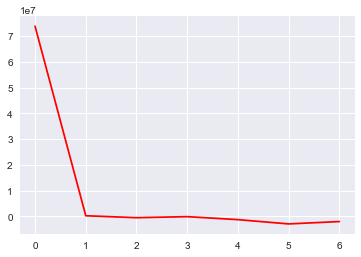

In [356]:
from scipy.signal import periodogram
c = np.fft.fft(prices[player1_id].price) # calculate fourier transform (complex numbers list)
#d = len(c)/2  # you only need half of the fft list (real signal symmetry)
plt.plot(c[:7],'r') 
plt.show()

Критерий Дики-Фуллера: p=0.543544


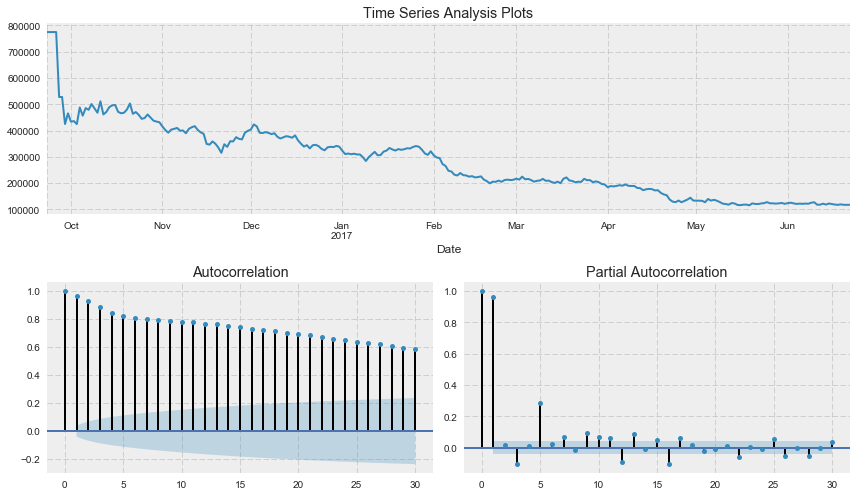

In [357]:
# код для отрисовки графиков
def tsplot(df, lags=None, figsize=(12, 7), style='bmh'):
   
    if not isinstance(df, pd.Series):
        y = df['price']
        y.index = df.Date
    else:
         y = df
            
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(player1_ts,lags = 30)

1539.0


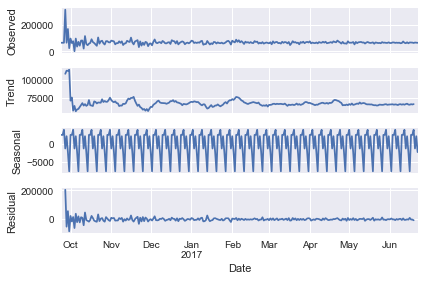

In [395]:
#plt.figure(figsize(15,10))
player1_ts_diff = player1_ts.shift(1) - player1_ts + 65000
player1_ts_diff = player1_ts_diff[1:]
print(player1_ts_diff.min())
sm.tsa.seasonal_decompose(player1_ts_diff).plot()
plt.show()

## Построение прогноза Prophet

In [396]:
# pip install pystan
# pip install fbprophet
from fbprophet import Prophet

In [397]:
predictions = 30

df = player1_ts_diff.reset_index()
df.columns = ['ds', 'y']
df.tail()

ds        y
267 2017-06-18  66085.0
268 2017-06-19  63262.0
269 2017-06-20  66603.0
270 2017-06-21  65256.0
271 2017-06-22  64593.0

In [398]:
train_df = df[:-predictions]
train_df.shape

(242, 2)

In [399]:
m = Prophet()
m.fit(train_df)

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [400]:
future = m.make_future_dataframe(periods=30)
future.tail()

ds
267 2017-06-18
268 2017-06-19
269 2017-06-20
270 2017-06-21
271 2017-06-22

In [401]:
forecast = m.predict(future)
forecast.tail()

ds         t         trend  seasonal_lower  seasonal_upper  \
267 2017-06-18  1.107884  63624.013673     1855.639084     1855.639084   
268 2017-06-19  1.112033  63597.230838     3552.364842     3552.364842   
269 2017-06-20  1.116183  63570.448002     -739.493742     -739.493742   
270 2017-06-21  1.120332  63543.665167     2887.599646     2887.599646   
271 2017-06-22  1.124481  63516.882331    -1670.805482    -1670.805482   

      trend_lower   trend_upper    yhat_lower    yhat_upper       weekly  \
267  63614.098255  63635.237361  37929.274071  92830.046472  1855.639084   
268  63586.541571  63609.247786  42557.441587  94445.485002  3552.364842   
269  63558.967708  63583.314297  36130.150172  88829.285475  -739.493742   
270  63531.593153  63557.261140  39348.698353  90160.950288  2887.599646   
271  63503.809225  63531.243046  35434.475958  89096.491455 -1670.805482   

     weekly_lower  weekly_upper     seasonal          yhat  
267   1855.639084   1855.639084  1855.639084  65479.652757  
268   3552.364842   3552.364842  3552.364842  67149.595680  
269   -739.493742   -739.493742  -739.493742  62830.954260  
270   2887.599646   2887.599646  2887.599646  66431.264813  
271  -1670.805482  -1670.805482 -1670.805482  61846.076849

In [402]:
print(', '.join(forecast.columns))

ds, t, trend, seasonal_lower, seasonal_upper, trend_lower, trend_upper, yhat_lower, yhat_upper, weekly, weekly_lower, weekly_upper, seasonal, yhat


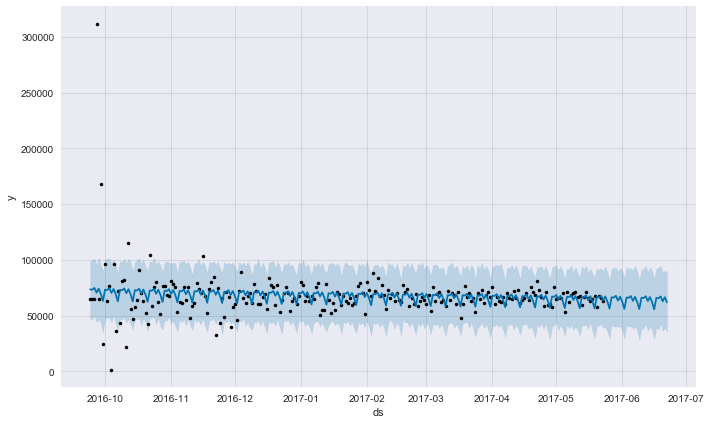

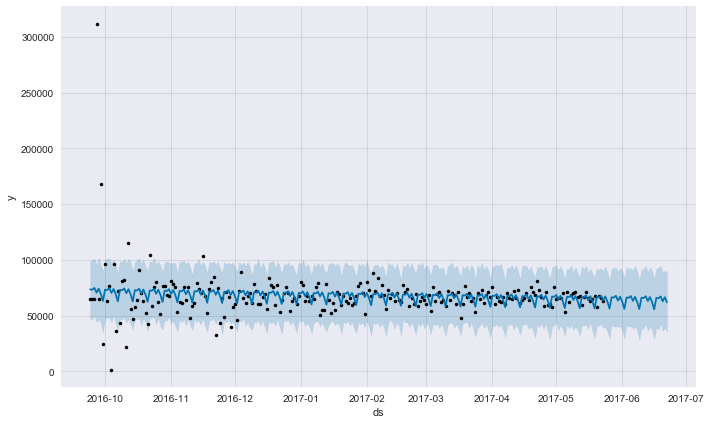

In [403]:
m.plot(forecast)

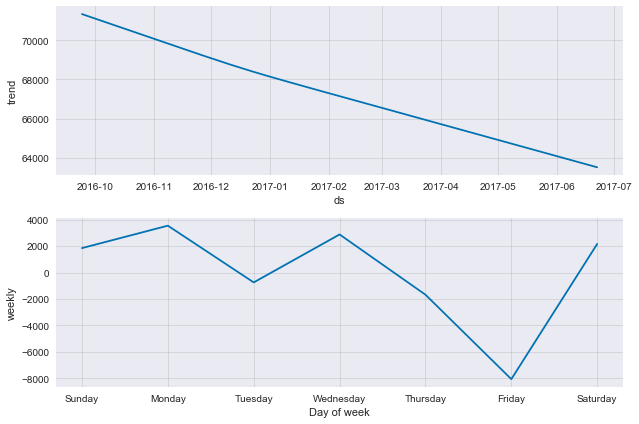

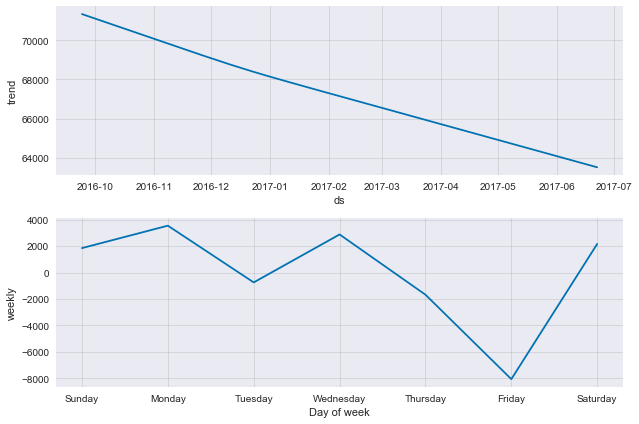

In [404]:
m.plot_components(forecast)

## Оценка качества Prophet

In [405]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [406]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
np.mean(abs(cmp_df[-predictions:]['p'])), np.mean(abs(cmp_df[-predictions:]['e']))

(4.8715190901922618, 3216.2225060861042)

In [407]:
show_forecast(cmp_df, predictions, 300)

## Прогноз с BoxCox

In [408]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

In [409]:
train_df.head()

ds         y
0 2016-09-24   65000.0
1 2016-09-25   65000.0
2 2016-09-26   65000.0
3 2016-09-27  312000.0
4 2016-09-28   65000.0

In [410]:
train_df2 = train_df.copy()
train_df2 = train_df2.set_index('ds')
train_df2['y'], lmbda_prophet = stats.boxcox(train_df2['y'])
print(lmbda_prophet)
train_df2.reset_index(inplace=True)
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=30)

forecast2 = m2.predict(future2)
forecast2['yhat'] = invboxcox(forecast2.yhat, lmbda_prophet)
forecast2['yhat_lower'] = invboxcox(forecast2.yhat_lower, lmbda_prophet)
forecast2['yhat_upper'] = invboxcox(forecast2.yhat_upper, lmbda_prophet)

cmp_df2 = forecast2.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

cmp_df2['e'] = cmp_df2['y'] - cmp_df2['yhat']
cmp_df2['p'] = 100*cmp_df2['e']/cmp_df2['y']
np.mean(abs(cmp_df2[-predictions:]['p'])), np.mean(abs(cmp_df2[-predictions:]['e']))

0.451385322835
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(5.8617385459380325, 3833.7244078902263)

## Визуализация результатов

In [411]:
def show_forecast(cmp_df, num_predictions, num_values):
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color="444"),
        line=dict(width=0),
        mode='lines')

    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    # Trace order can be important
    # with continuous error bars
    data = [lower_bound,  forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Посты'),
        title='Опубликованные посты на Хабрахабре',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [412]:
show_forecast(cmp_df2, predictions, 300)

##  Сравнение с ARIMA моделью

In [256]:
train_df = train_df.fillna(14).set_index('ds')

Критерий Дики-Фуллера: p=0.794351


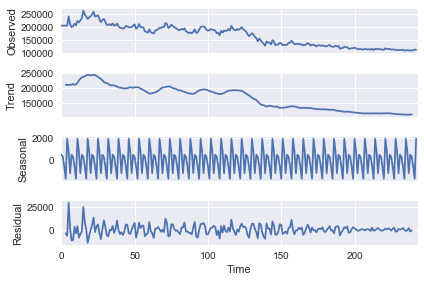

In [257]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

In [258]:
train_df.index = pd.to_datetime(train_df.index)

Оптимальный параметр преобразования Бокса-Кокса: 0.306269
Критерий Дики-Фуллера: p=0.794351


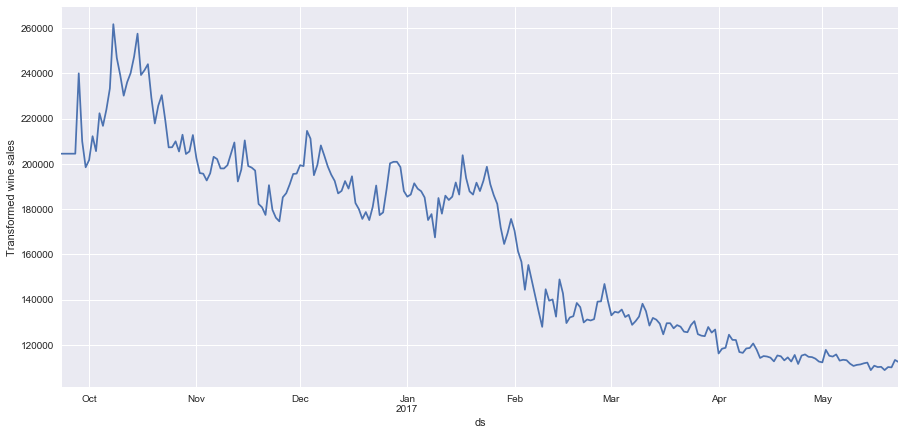

In [259]:
train_df['y_box'], lmbda = stats.boxcox([1 if x == 0 else x for x in train_df['y']])
plt.figure(figsize=(15,7))
train_df.y.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

Критерий Дики-Фуллера: p=0.000104


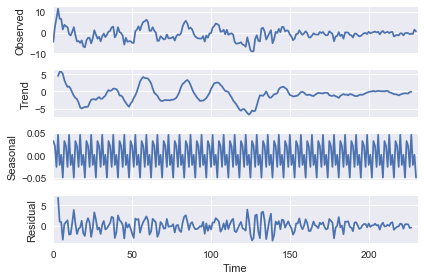

In [262]:
train_df['y_box_diff'] = train_df.y_box - train_df.y_box.shift(7)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df.y_box_diff[12:].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_box_diff[8:])[1])

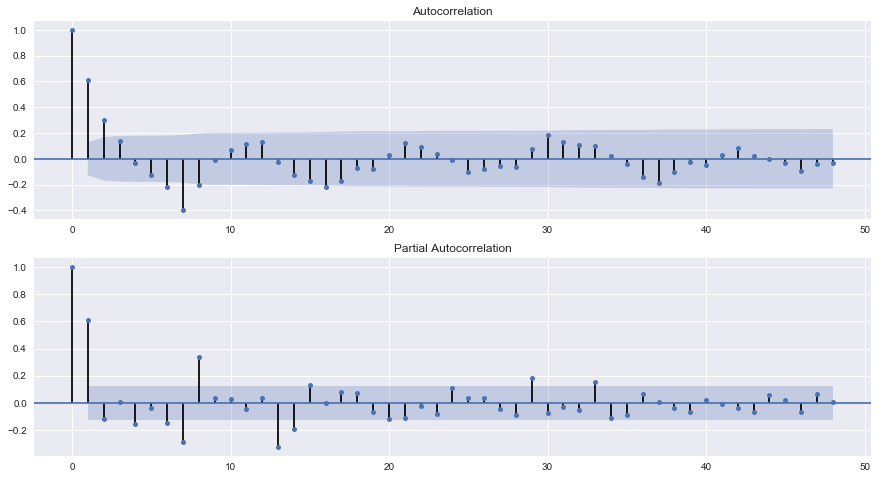

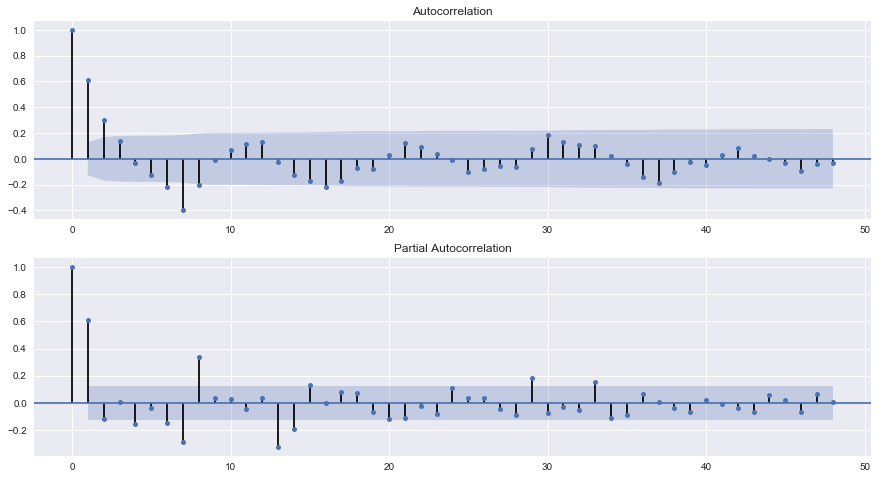

In [177]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_box_diff[7:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_box_diff[7:].values.squeeze(), lags=48, ax=ax)

Начальные приближения Q = 1, q = 4, P = 5, p = 3

In [178]:
ps = range(0, 7)
d=0
qs = range(0, 7)
Ps = range(0, 6)
D=1
Qs = range(0, 2)

In [179]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

588

In [180]:
%%time
results = []
best_aic = float("inf")



for param in parameters_list:
    print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df.y_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)
wrong parameters: (0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 2, 0)
(0, 0, 2, 1)
(0, 0, 3, 0)
(0, 0, 3, 1)
(0, 0, 4, 0)
(0, 0, 4, 1)
(0, 0, 5, 0)
(0, 0, 5, 1)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 2, 0)
(0, 1, 2, 1)
(0, 1, 3, 0)
(0, 1, 3, 1)
(0, 1, 4, 0)
(0, 1, 4, 1)
(0, 1, 5, 0)
(0, 1, 5, 1)
(0, 2, 0, 0)
(0, 2, 0, 1)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 2, 0)
(0, 2, 2, 1)
(0, 2, 3, 0)
(0, 2, 3, 1)
(0, 2, 4, 0)
(0, 2, 4, 1)
(0, 2, 5, 0)
(0, 2, 5, 1)
(0, 3, 0, 0)
(0, 3, 0, 1)
(0, 3, 1, 0)
wrong parameters: (0, 3, 1, 0)
(0, 3, 1, 1)
wrong parameters: (0, 3, 1, 1)
(0, 3, 2, 0)
wrong parameters: (0, 3, 2, 0)
(0, 3, 2, 1)
wrong parameters: (0, 3, 2, 1)
(0, 3, 3, 0)
wrong parameters: (0, 3, 3, 0)
(0, 3, 3, 1)
wrong parameters: (0, 3, 3, 1)
(0, 3, 4, 0)
wrong parameters: (0, 3, 4, 0)
(0, 3, 4, 1)
wrong parameters: (0, 3, 4, 1)
(0, 3, 5, 0)
wrong parameters: (0, 3, 5, 0)
(0, 3, 5, 1)
wrong parameters: (0, 3, 5, 1)
(0, 4, 0, 0)
(0, 4, 0, 1)
(0, 4, 1,

LinAlgError: Singular matrix

In [181]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
87   (1, 3, 5, 0) -2348.887876
126  (2, 0, 0, 1) -2345.525492
76   (1, 2, 5, 1) -2345.094365
66   (1, 2, 0, 1) -2343.209789
44   (1, 0, 0, 1) -2342.557687


In [182]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                  243
Model:             SARIMAX(1, 0, 3)x(5, 1, 0, 7)   Log Likelihood                1184.444
Date:                           Sat, 01 Jul 2017   AIC                          -2348.888
Time:                                   09:07:33   BIC                          -2313.957
Sample:                               09-23-2016   HQIC                         -2334.818
                                    - 05-23-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8181      0.096      8.537      0.000       0.630       1.006
ma.L1         -0.0117      0.121     -0.097

Критерий Стьюдента: p=0.133002
Критерий Дики-Фуллера: p=0.000000


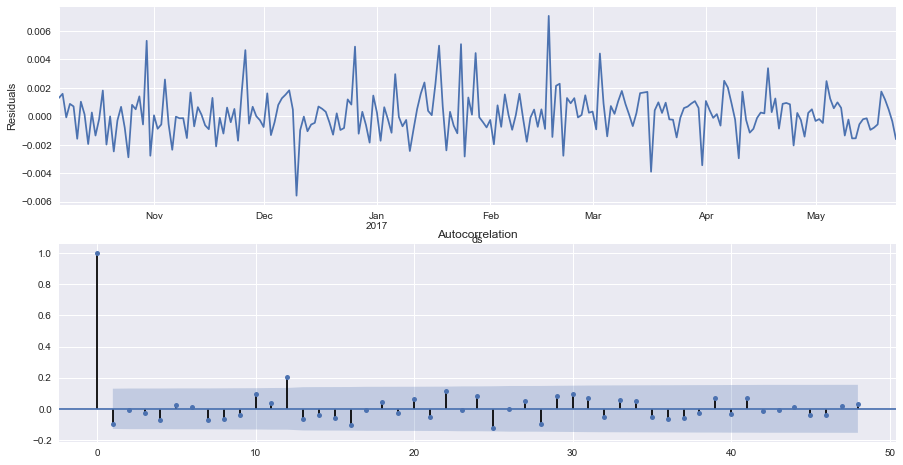

In [183]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

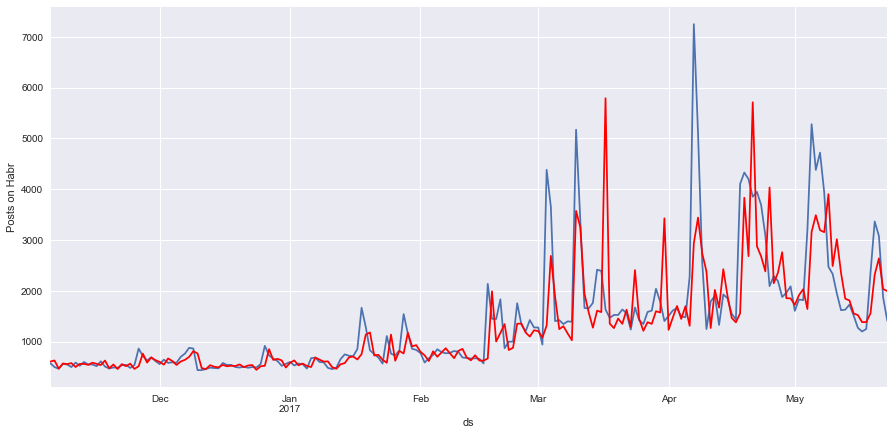

In [184]:
train_df['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color='r')
plt.ylabel('Posts on Habr');

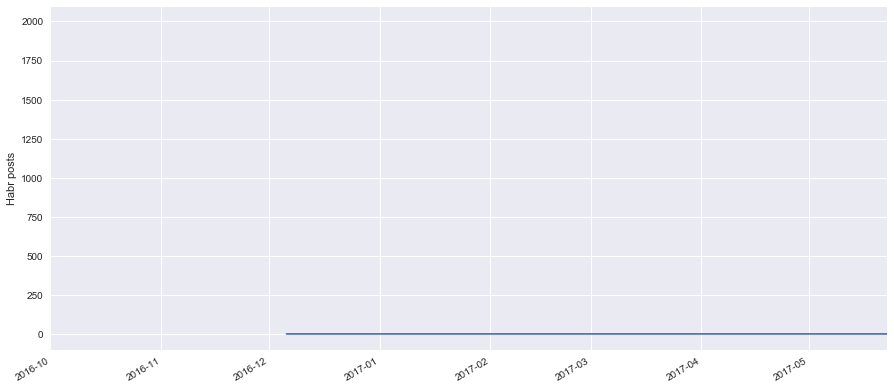

In [185]:
arima_df = train_df2.set_index('ds')[['y']]

date_list = [pd.datetime.strptime("2016-10-01", "%Y-%m-%d") + 
             pd.Timedelta(x) for x in range(0, predictions+1)]
future = pd.DataFrame(index=date_list, columns= arima_df.columns)
arima_df = pd.concat([arima_df, future])
arima_df['forecast'] = invboxcox(best_model.predict(start=train_df.shape[0]-1, end=train_df.shape[0]+predictions-1), lmbda)
plt.figure(figsize=(15,7))
arima_df.y.tail(200).plot()
arima_df.forecast.tail(200).plot(color='r')
plt.ylabel('Habr posts');

In [186]:
cmp_df.head()

yhat    yhat_lower    yhat_upper    y             e  \
ds                                                                        
2016-09-23  34309.645079  30934.008013  37675.086963  450 -33859.645079   
2016-09-24  34098.138810  30628.950619  37466.582409  450 -33648.138810   
2016-09-25  33693.163061  30361.859082  37156.469028  450 -33243.163061   
2016-09-26  33259.497193  29612.757778  36601.915464  450 -32809.497193   
2016-09-27  33522.204257  30390.697880  36960.638343  650 -32872.204257   

                      p  
ds                       
2016-09-23 -7524.365573  
2016-09-24 -7477.364180  
2016-09-25 -7387.369569  
2016-09-26 -7290.999376  
2016-09-27 -5057.262193

In [187]:
cmp_df = cmp_df.join(arima_df[['forecast']])

In [188]:
import numpy as np
cmp_df['e_arima'] = cmp_df['y'] - cmp_df['forecast']
cmp_df['p_arima'] = 100*cmp_df['e_arima']/cmp_df['y']
np.mean(abs(cmp_df2[-predictions:]['p'])), np.mean(abs(cmp_df2[-predictions:]['e']))

(31.351702553036262, 662.22412451958007)

In [189]:
np.mean(abs(cmp_df[-predictions:]['p'])), np.mean(abs(cmp_df[-predictions:]['e']))

(592.69009980451813, 10395.241027161304)

In [190]:
num_values = 200

forecast = go.Scatter(
    name='Prophet',
    x=cmp_df.tail(predictions).index,
    y=cmp_df.tail(predictions).yhat,
    mode='lines',
    line=dict(color='rgb(31, 119, 180)'),
)


fact = go.Scatter(
    name='Fact',
    x=cmp_df.tail(num_values).index,
    y=cmp_df.tail(num_values).y,
    marker=dict(color="red"),
    mode='lines',
)

arima = go.Scatter(
    name='ARIMA',
    x=cmp_df.tail(predictions).index,
    y=cmp_df.tail(predictions).forecast,
    mode='lines'
)

# Trace order can be important
# with continuous error bars
data = [forecast, fact, arima]

layout = go.Layout(
    yaxis=dict(title='Посты'),
    title='Опубликованные посты на Хабрахабре',
    showlegend = True)

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)